## Retail Store Sales Forecasting with Neural Networks -
## ARMA, ARIMA, Seasonal ARIMA , and Auto-ARIMA method
## By Yasaman Ensafi - 500913843
### Ryerson Data Science and Analytics (MSc)
#### 2019

## Import libraries

In [54]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sys

from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
import warnings

from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

## Load Dataset

In [55]:
data= pd.read_excel('Sample_Superstore.xls')

## Edit columns names

In [56]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## Separate dataframe of each category

In [57]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

## Aggregating sales data by date

In [58]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [59]:
#Set index 
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

In [60]:
#furniture['sales']

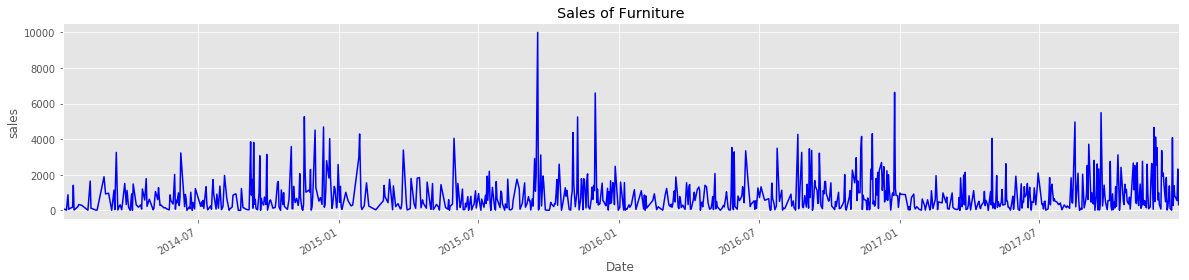

In [61]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furniture")
plt.show()

In [62]:
#Resampling the data on monthly frequency
# Using averages daily sales value - set start of the month as index
df = furniture['sales'].resample('MS').mean()

#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

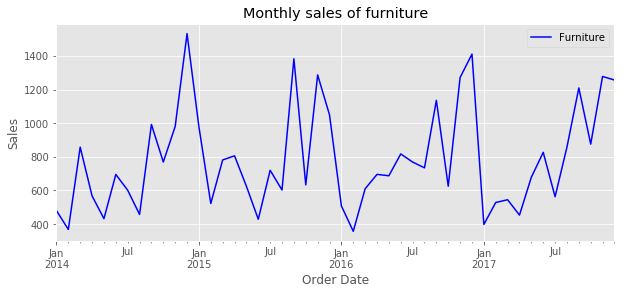

In [63]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

## Seasonal decomposition:

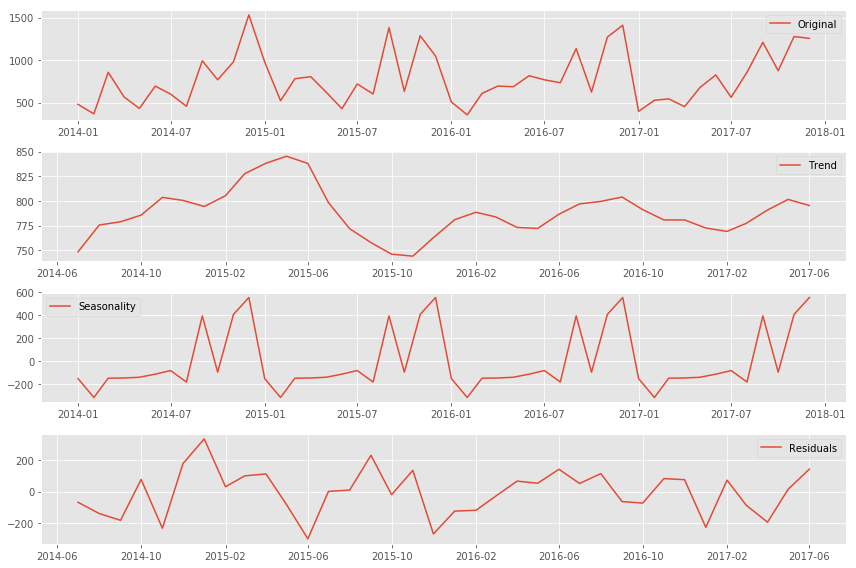

In [64]:
#Furniture time-series decomposition
decomposition = seasonal_decompose(df,freq=12)
rcParams['figure.figsize'] = 12, 8

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [65]:
def test_stationarity(timeseries):
    rcParams['figure.figsize'] = 10, 6
    rolmean = timeseries.rolling(12).mean() #allows you to calculate moving avg
    rolstd = timeseries.rolling(12).std() 
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print('p-value=', dftest[1])

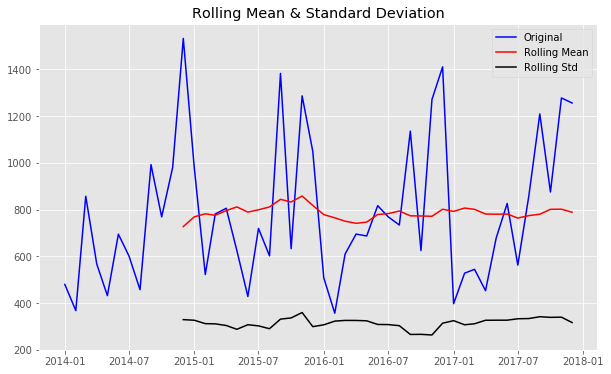

Results of Dickey-Fuller Test:
p-value= 9.168756655665942e-06


In [66]:
#check to see if the time-series is stationary or non-stationary
test_stationarity(df)
#p-value= 9.168756655665942e-06

### Train and test split

In [67]:
X = df
train_size = int(len(X) * 0.75)
trainset, testset= X[0:train_size], X[train_size:]

### Measure of prediction accuracy

In [68]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

## ARMA model

In [69]:
from statsmodels.tsa.arima_model import ARMA
model_arma = ARMA(trainset, order = (1,1))
model_arma_fit = model_arma.fit(disp=False)
arma_predict = model_arma_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)

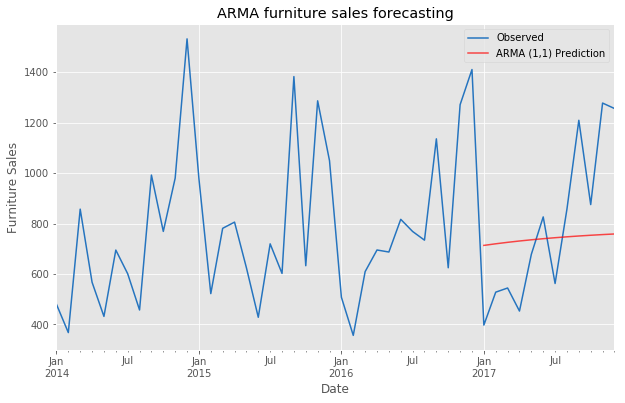

In [70]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arma_predict.plot(ax=ax, label='ARMA (1,1) Prediction', alpha= 0.7, color='red') 
plt.title('ARMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()



In [71]:
arma_results= performance(df[-12:],arma_predict)
arma_results

{'MSE': 87237.01, 'RMSE': 295.36, 'MAPE': 33.88}

## ARIMA model

### Grid Search

In [72]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [73]:
# evaluate parameters
p_values = [0, 1, 2, 4,6]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=94274.549
ARIMA(0, 0, 1) MSE=87692.922
ARIMA(0, 1, 0) MSE=144690.584
ARIMA(0, 1, 1) MSE=109451.878
ARIMA(1, 0, 0) MSE=90148.329
ARIMA(1, 0, 1) MSE=77815.706
ARIMA(1, 1, 0) MSE=135393.556
ARIMA(1, 1, 1) MSE=103592.629
ARIMA(2, 0, 0) MSE=94447.876
ARIMA(2, 0, 1) MSE=94094.965
ARIMA(2, 1, 0) MSE=115636.954
ARIMA(2, 1, 1) MSE=113894.188
ARIMA(4, 0, 0) MSE=73497.716
ARIMA(4, 1, 0) MSE=116440.530
ARIMA(4, 1, 1) MSE=91729.204
ARIMA(6, 0, 0) MSE=71586.494
ARIMA(6, 1, 0) MSE=110700.341
ARIMA(6, 1, 1) MSE=91373.178
Best ARIMA(6, 0, 0) MSE=71586.494


#### Source: 
    
https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [74]:
from statsmodels.tsa.arima_model import ARIMA
model_arima = ARIMA(trainset, order = (6,0,0))
model_arima_fit = model_arima.fit(disp=False)
arima_predict = model_arima_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)

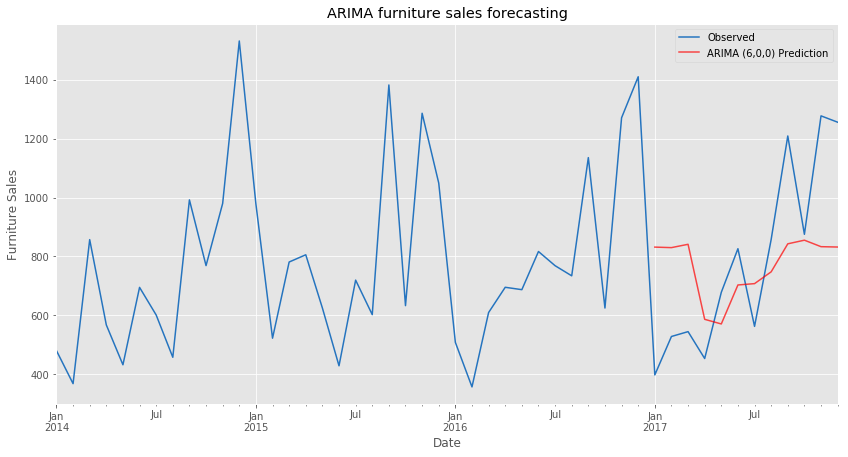

In [75]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arima_predict.plot(ax=ax, label='ARIMA (6,0,0) Prediction', alpha= 0.7, color='red') 
plt.title('ARIMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [76]:
arima_results= performance(df[-12:],arima_predict)
arima_results

{'MSE': 79804.31, 'RMSE': 282.5, 'MAPE': 35.07}

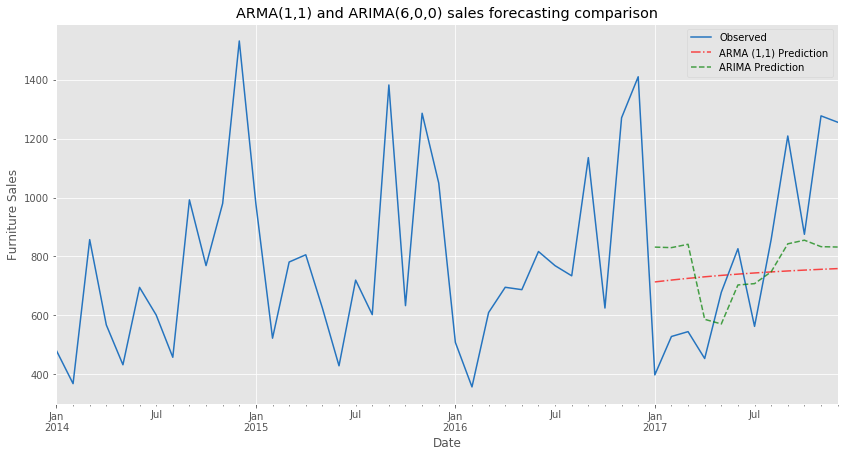

In [77]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arma_predict.plot(ax=ax,label='ARMA (1,1) Prediction', linestyle= '-.', alpha= 0.7, color='r')
arima_predict.plot(ax=ax, label='ARIMA Prediction', linestyle= "--" ,alpha= 0.7, color='g')
plt.title('ARMA(1,1) and ARIMA(6,0,0) sales forecasting comparison')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()





## ACF plot

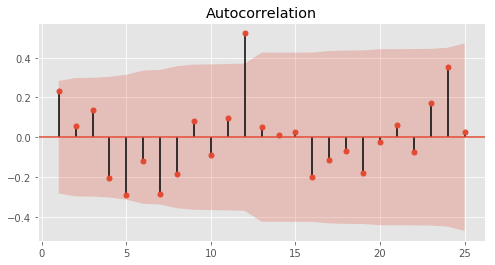

In [78]:
from statsmodels.graphics.tsaplots import plot_acf
fig,ax = plt.subplots(1,1,figsize=(8,4))
plot_acf(df,ax=ax,zero=False,lags=25)
plt.show()

#From the peaks we can see that the frequency is 12

## Seasonal ARIMA model

### Grid search method 1 - using auto-ARIMA that reported back the best AIC value.

In [79]:
## Find optimal order
import pmdarima as pm
model_1 = pm.auto_arima(trainset,seasonal=True, m=12,d=0, D=1, max_p=2, max_q=2,
                       trace=True,error_action='ignore',suppress_warnings=True) 

# Print model summary
print(model_1.summary())

#best model is Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=329.940,

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=338.682, BIC=341.038, Fit time=0.017 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=331.614, BIC=336.327, Fit time=0.278 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=340.006, BIC=343.540, Fit time=0.081 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=329.940, BIC=333.474, Fit time=0.193 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=331.653, BIC=336.366, Fit time=0.27

### Fitting the model

In [80]:
#fitting model
sarima_model_1 = sm.tsa.statespace.SARIMAX(trainset,
                                order=(0, 0, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit_1 = sarima_model_1.fit()
print(sarima_fit_1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6292      0.176     -3.570      0.000      -0.975      -0.284
sigma2       2.25e+04   1.57e+04      1.429      0.153   -8356.220    5.34e+04


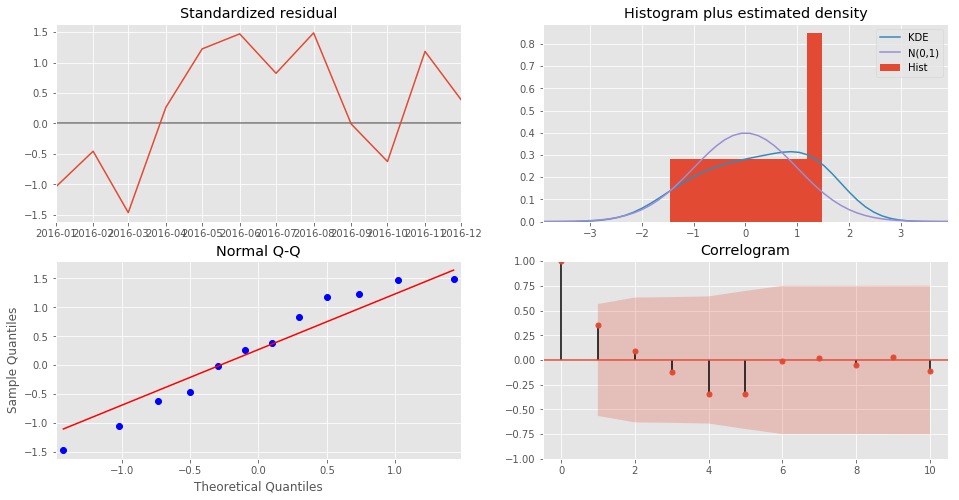

In [81]:
sarima_fit_1.plot_diagnostics(figsize=(16, 8))
plt.show()

### Validating forecasts

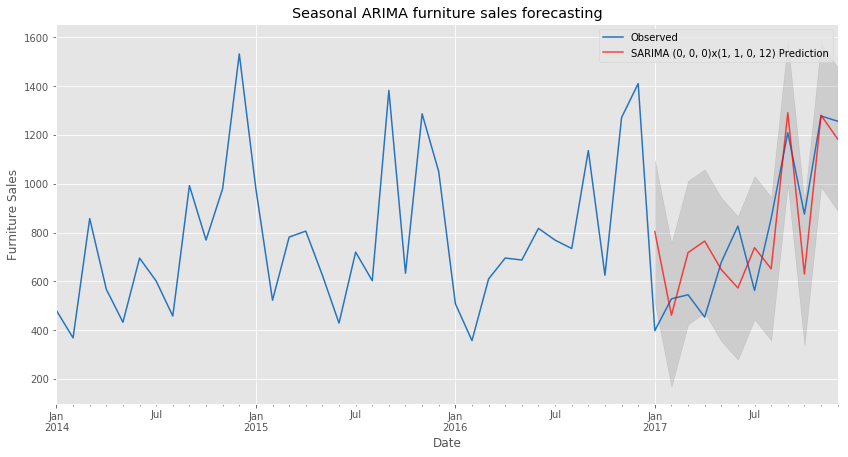

In [82]:
# One step ahead forecastorder
sarima_predict_1 = sarima_fit_1.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)
sarima_predict_conf_1 = sarima_predict_1.conf_int()
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
sarima_predict_1.predicted_mean.plot(ax=ax, label='SARIMA (0, 0, 0)x(1, 1, 0, 12) Prediction', alpha= 0.7, color='red') 
ax.fill_between(sarima_predict_conf_1.index,
                #lower sales
                sarima_predict_conf_1.iloc[:, 0],
                #upper sales
                sarima_predict_conf_1.iloc[:, 1], color='k', alpha=0.1)
plt.title('Seasonal ARIMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()


In [83]:
sarima_results=performance(df[-12:],sarima_predict_1.predicted_mean)
sarima_results

{'MSE': 42305.37, 'RMSE': 205.68, 'MAPE': 28.89}

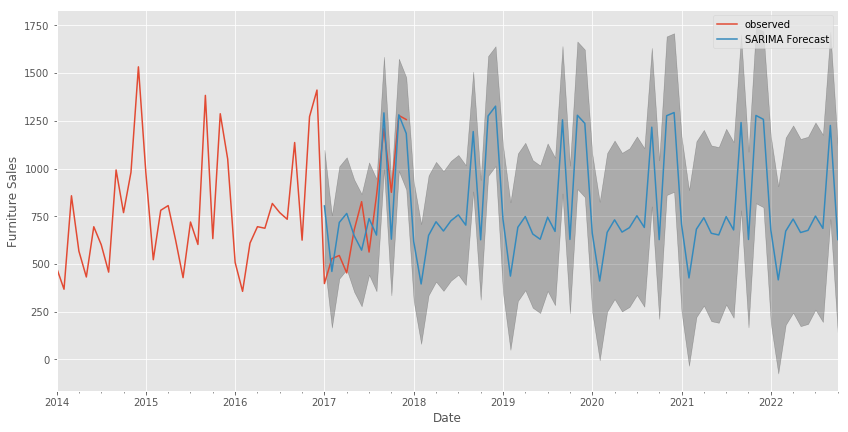

In [84]:
furthur_predict_1 = sarima_fit_1.get_forecast(steps=70)
furthur_conf_1 = furthur_predict_1.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
furthur_predict_1.predicted_mean.plot(ax=ax, label='SARIMA Forecast')
ax.fill_between(furthur_conf_1.index,
                furthur_conf_1.iloc[:, 0],
                furthur_conf_1.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Grid Search meethod 2 - Develop a Grid Search Framework

In [85]:
# Define the p, d and q parameters to take a value between 0 and 2
p = d = q = range(0, 2)

# Generate different combinations of p, d and q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [86]:
#method 2
warnings.filterwarnings("ignore")
lowest_aic = sys.maxsize
lowest = ''

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(trainset,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("The lowes AIC belongs to "+lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:573.2736548047211
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:320.39031701172337
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:339.13659906594717
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:158.31115188193314
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:535.956097491259
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:308.98276881122155
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:340.55729582954075
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:158.06483656135666
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:501.6523533373235
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:319.3351634712986
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:330.687098693596
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:145.77300556718512
SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:477.6653149075071
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:299.4712944291711
SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:327.5605738441135
SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:147.21230738075826
SARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:516.6922617187157
SARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:321.

### Fitting the model

In [87]:
#fitting model
sarima_model_2 = sm.tsa.statespace.SARIMAX(trainset,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit_2 = sarima_model_2.fit()
print(sarima_fit_2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1918      0.371     -0.517      0.606      -0.920       0.536
ar.S.L12      -0.4818      0.165     -2.922      0.003      -0.805      -0.159
sigma2      2.266e+04    1.8e+04      1.259      0.208   -1.26e+04    5.79e+04


### Validating forecasts

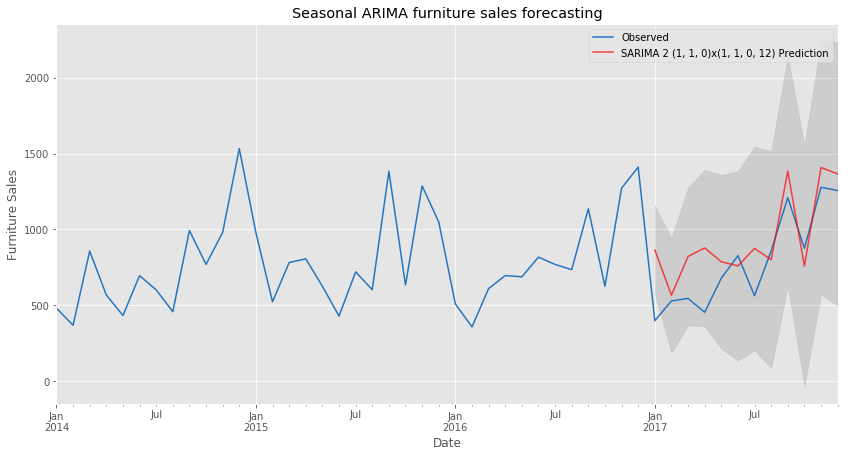

In [88]:
# One step ahead forecast
sarima_predict_2 = sarima_fit_2.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)
sarima_predict_conf_2 = sarima_predict_2.conf_int()
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
sarima_predict_2.predicted_mean.plot(ax=ax, label='SARIMA 2 (1, 1, 0)x(1, 1, 0, 12) Prediction', alpha= 0.7, color='red') 
ax.fill_between(sarima_predict_conf_2.index,
                #lower sales
                sarima_predict_conf_2.iloc[:, 0],
                #upper sales
                sarima_predict_conf_2.iloc[:, 1], color='k', alpha=0.1)
plt.title('Seasonal ARIMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()


In [89]:
sarima_results2=performance(df[-12:],sarima_predict_2.predicted_mean)
sarima_results2

{'MSE': 55497.86, 'RMSE': 235.58, 'MAPE': 33.5}

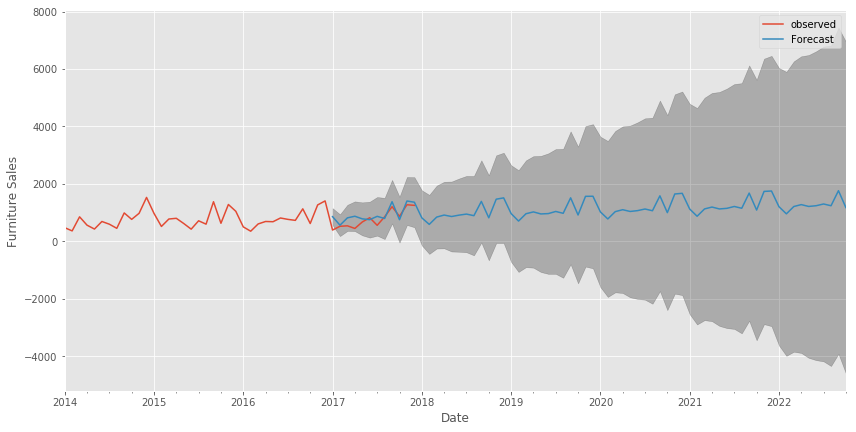

In [90]:
furthur_predict_2 = sarima_fit_2.get_forecast(steps=70)
furthur_conf_2 = furthur_predict_2.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
furthur_predict_2.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(furthur_conf_2.index,
                furthur_conf_2.iloc[:, 0],
                furthur_conf_2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Comparison

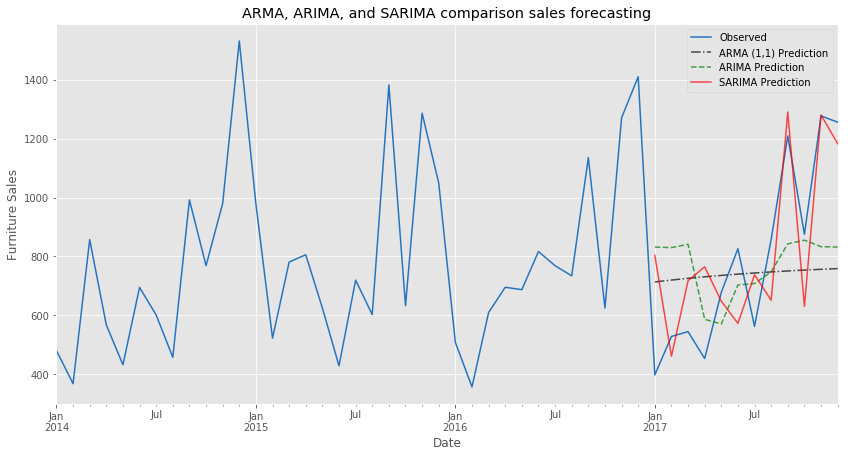

In [91]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arma_predict.plot(ax=ax,label='ARMA (1,1) Prediction', linestyle= '-.', alpha= 0.7, color='k')
arima_predict.plot(ax=ax, label='ARIMA Prediction', linestyle= "--" ,alpha= 0.7, color='g')
sarima_predict_1.predicted_mean.plot(ax=ax, label='SARIMA Prediction', alpha= 0.7, color='red') 
plt.title('ARMA, ARIMA, and SARIMA comparison sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()




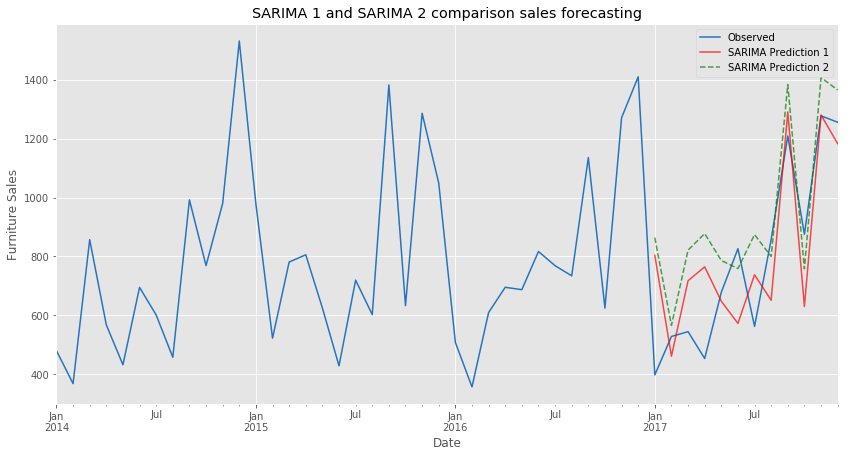

In [92]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
sarima_predict_1.predicted_mean.plot(ax=ax, label='SARIMA Prediction 1', alpha= 0.7,linestyle= "-", color='red') 
sarima_predict_2.predicted_mean.plot(ax=ax, label='SARIMA Prediction 2', linestyle= "--", alpha= 0.7, color='g')

plt.title('SARIMA 1 and SARIMA 2 comparison sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()


## Double exponential smoothing

In [93]:
#Prediction with double exponential smoothing
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing

DES = ExponentialSmoothing(trainset, trend = 'add')
DES_fit = DES.fit(smoothing_level=0.5)
DES_predict = DES_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01'))

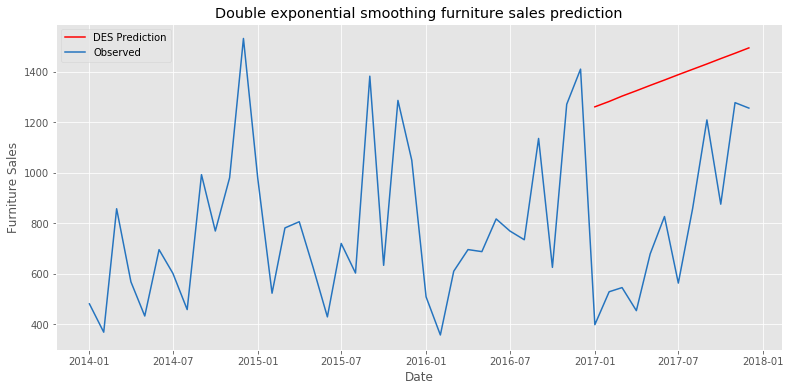

In [94]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
yhat_DES = DES_predict.values.tolist()
y = df.values.tolist()
plt.plot(DES_predict.index, yhat_DES, color='r',label='DES Prediction')
plt.plot(df.index, y, color='#2574BF',label='Observed')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Double exponential smoothing furniture sales prediction')
plt.show()

In [95]:
DES_results=performance(df[-12:], yhat_DES)
DES_results

{'MSE': 404596.36, 'RMSE': 636.08, 'MAPE': 98.79}

### Triple exponential smoothing

In [96]:
#Prediction with exponential smoothing + seasonality
from statsmodels.tsa.holtwinters import ExponentialSmoothing
TES = ExponentialSmoothing(trainset, trend = 'add', seasonal = 'add', seasonal_periods = 12)
TES_fit = TES.fit(smoothing_level=0.5)
TES_predict = TES_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01'))

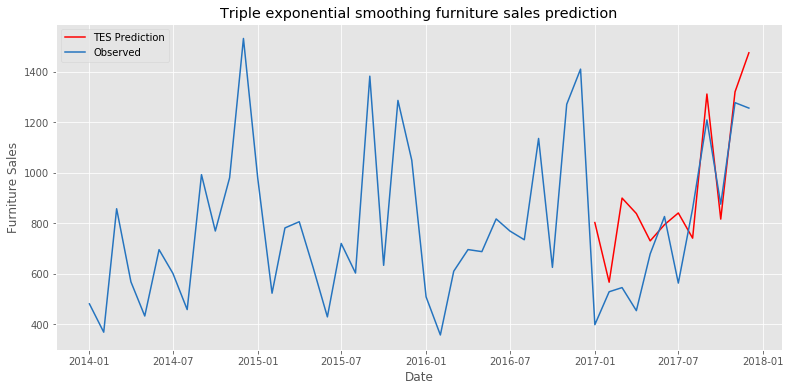

In [97]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
yhat_TES = TES_predict.values.tolist()
y = df.values.tolist()
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction')
plt.plot(df.index, y, color='#2574BF',label='Observed')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Triple exponential smoothing furniture sales prediction')
plt.show()

In [98]:
TES_results= performance(df[-12:], yhat_TES)
TES_results

{'MSE': 49846.48, 'RMSE': 223.26, 'MAPE': 30.81}

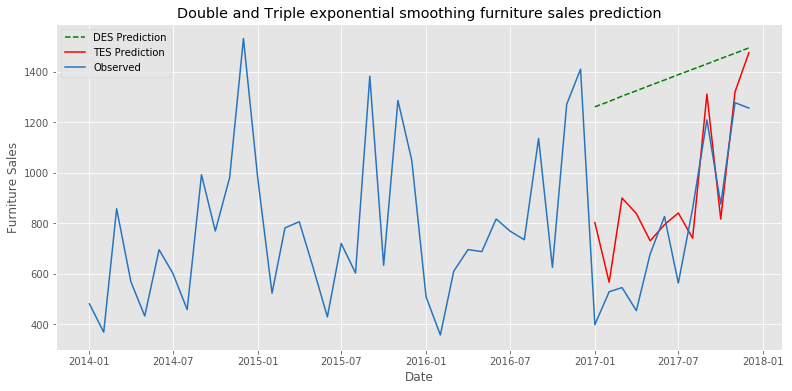

In [99]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.plot(DES_predict.index, yhat_DES, color='g',linestyle= "--",label='DES Prediction')
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction')
plt.plot(df.index, y, color='#2574BF',label='Observed')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Double and Triple exponential smoothing furniture sales prediction')
plt.show()

## Prophet Method

### Prophet First model

In [100]:
df_furniture_train = pd.DataFrame({'order_date':trainset.index, 'sales':trainset.values})
df_furniture_test = pd.DataFrame({'order_date':testset.index, 'sales':testset.values})

In [101]:
warnings.filterwarnings("ignore")
from fbprophet import Prophet
df_furniture_train = df_furniture_train.rename(columns={'order_date': 'ds', 'sales': 'y'})
df_furniture_test = df_furniture_test.rename(columns={'order_date': 'ds', 'sales': 'y'})

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [102]:
warnings.filterwarnings("ignore")
# set the uncertainty interval to 95% (Prophet default is 80%)
furniture_model = Prophet(interval_width=0.95, yearly_seasonality=True)
furniture_model.fit(df_furniture_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [103]:
furniture_forecast = furniture_model.make_future_dataframe(periods=12, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

<Figure size 1296x432 with 0 Axes>

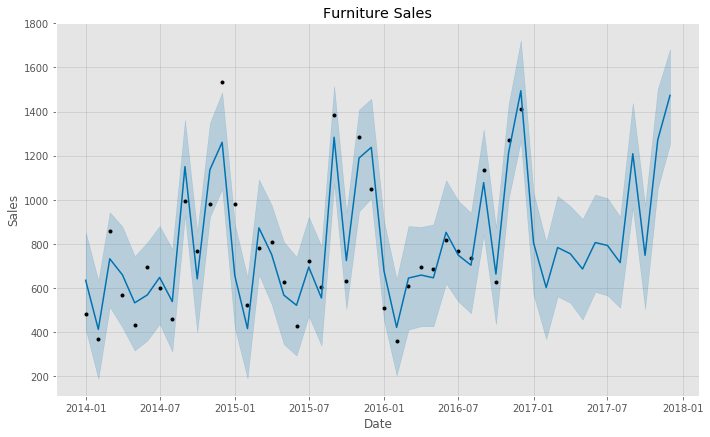

In [104]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')
plt.show()

In [105]:
furniture_forecast.drop(columns=['multiplicative_terms', 'multiplicative_terms_lower','multiplicative_terms_upper'])

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,2014-01-01,681.588219,412.283017,852.329691,681.588219,681.588219,-47.448838,-47.448838,-47.448838,-47.448838,-47.448838,-47.448838,634.139381
1,2014-02-01,685.636335,186.789080,632.697913,685.636335,685.636335,-274.076247,-274.076247,-274.076247,-274.076247,-274.076247,-274.076247,411.560088
2,2014-03-01,689.292697,513.458604,942.729257,689.292697,689.292697,42.432009,42.432009,42.432009,42.432009,42.432009,42.432009,731.724706
3,2014-04-01,693.340812,420.270871,877.390039,693.340812,693.340812,-34.565068,-34.565068,-34.565068,-34.565068,-34.565068,-34.565068,658.775745
4,2014-05-01,697.258344,315.677082,743.322895,697.258344,697.258344,-165.311506,-165.311506,-165.311506,-165.311506,-165.311506,-165.311506,531.946837
5,2014-06-01,701.306459,361.269230,806.315313,701.306459,701.306459,-133.386474,-133.386474,-133.386474,-133.386474,-133.386474,-133.386474,567.919985
6,2014-07-01,705.223990,436.410089,880.407863,705.223990,705.223990,-58.042923,-58.042923,-58.042923,-58.042923,-58.042923,-58.042923,647.181067
7,2014-08-01,709.272106,311.034283,775.483807,709.272106,709.272106,-171.626465,-171.626465,-171.626465,-171.626465,-171.626465,-171.626465,537.645640
8,2014-09-01,713.320221,930.340641,1362.158817,713.320221,713.320221,436.759246,436.759246,436.759246,436.759246,436.759246,436.759246,1150.079467
9,2014-10-01,717.237752,397.814825,852.345221,717.237752,717.237752,-76.340818,-76.340818,-76.340818,-76.340818,-76.340818,-76.340818,640.896934


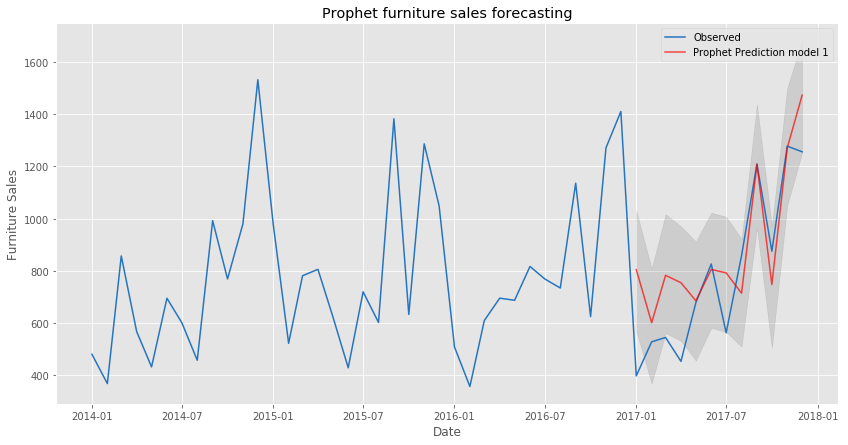

In [106]:
rcParams['figure.figsize'] = 14, 7
plt.plot(df.index, df.values,label='Observed',color='#2574BF')
plt.plot(df[36:48].index,furniture_forecast[36:48]['yhat'].values,label='Prophet Prediction model 1', alpha= 0.7, color='red')
plt.fill_between(df[36:48].index,
                #lower sales
                furniture_forecast[36:48]['yhat_lower'].values,
                #upper sales
                furniture_forecast[36:48]['yhat_upper'].values, color='k', alpha=0.1)
plt.title('Prophet furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [107]:
prophet_results=performance(df[36:48].values, furniture_forecast[36:48]['yhat'])
prophet_results

{'MSE': 37992.52, 'RMSE': 194.92, 'MAPE': 26.67}

In [108]:
test= furniture_forecast.set_index('ds')

### Prophet Second model

In [109]:
#add holidays
new_year_holidays = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2014-01-01', '2015-01-01','2016-01-01'])}) 

furniture_model2 = Prophet(yearly_seasonality=True, holidays=new_year_holidays)
furniture_model2.fit(df_furniture_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [110]:
furniture_forecast2 = furniture_model2.make_future_dataframe(periods=36, freq='MS')
furniture_forecast2 = furniture_model2.predict(furniture_forecast2)

<Figure size 1296x432 with 0 Axes>

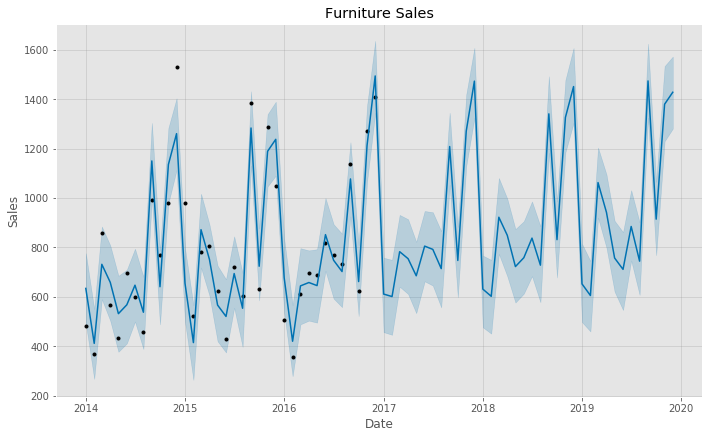

In [111]:
plt.figure(figsize=(18, 6))
furniture_model2.plot(furniture_forecast2, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')
plt.show()

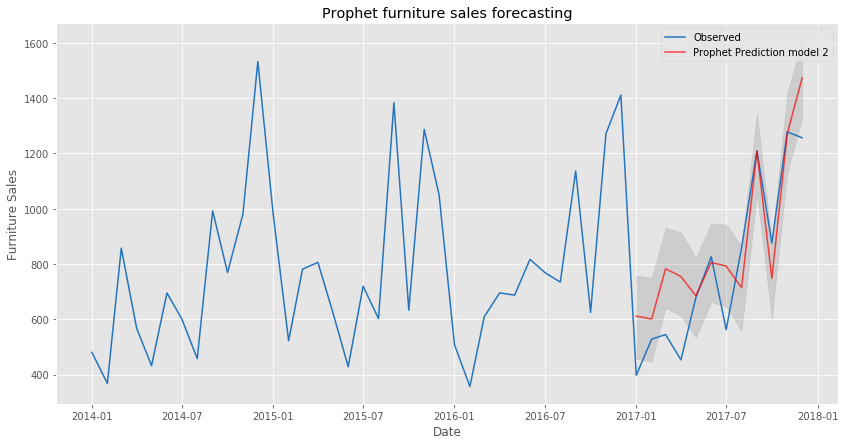

In [112]:
rcParams['figure.figsize'] = 14, 7
plt.plot(df.index, df.values,label='Observed',color='#2574BF')
plt.plot(df[36:48].index,furniture_forecast2[36:48]['yhat'].values,label='Prophet Prediction model 2', alpha= 0.7, color='red')
plt.fill_between(df[36:48].index,
                #lower sales
                furniture_forecast2[36:48]['yhat_lower'].values,
                #upper sales
                furniture_forecast2[36:48]['yhat_upper'].values, color='k', alpha=0.1)
plt.title('Prophet furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [113]:
prophet_results2= performance(df[36:48].values, furniture_forecast2[36:48]['yhat'])
prophet_results

{'MSE': 37992.52, 'RMSE': 194.92, 'MAPE': 26.67}

In [114]:
test2= furniture_forecast2.set_index('ds')

## LSTM

In [125]:
train, test = np.array(df[:-12]), np.array(df[-12:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [126]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [127]:
n_input = 12
# Univariate
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10) #or6

### Vanilla LSTM

In [150]:
warnings.filterwarnings("ignore")
model_vanilla = Sequential()
model_vanilla.add(LSTM(50, activation='relu', input_shape=(12, 1)))
#Add layer
model_vanilla.add(Dense(100, activation='relu'))
model_vanilla.add(Dense(100, activation='relu'))
#Output
model_vanilla.add(Dense(1))
model_vanilla.compile(optimizer='adam', loss='mse')
# 22

In [151]:
model_vanilla.fit_generator(generator,epochs=200)

Epoch 1/200
3/3 [==============================] - 2s 512ms/step - loss: 0.2486
Epoch 2/200
3/3 [==============================] - 0s 22ms/step - loss: 0.2153
Epoch 3/200
3/3 [==============================] - 0s 34ms/step - loss: 0.1858
Epoch 4/200
3/3 [==============================] - 0s 36ms/step - loss: 0.1598
Epoch 5/200
3/3 [==============================] - 0s 31ms/step - loss: 0.1314
Epoch 6/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0981
Epoch 7/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0872
Epoch 8/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0745
Epoch 9/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0835
Epoch 10/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0833
Epoch 11/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0813
Epoch 12/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0800
Epoch 13/200
3/3 [==============================

In [152]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model_vanilla.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

df_predict_vanilla = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict_vanilla], axis=1)

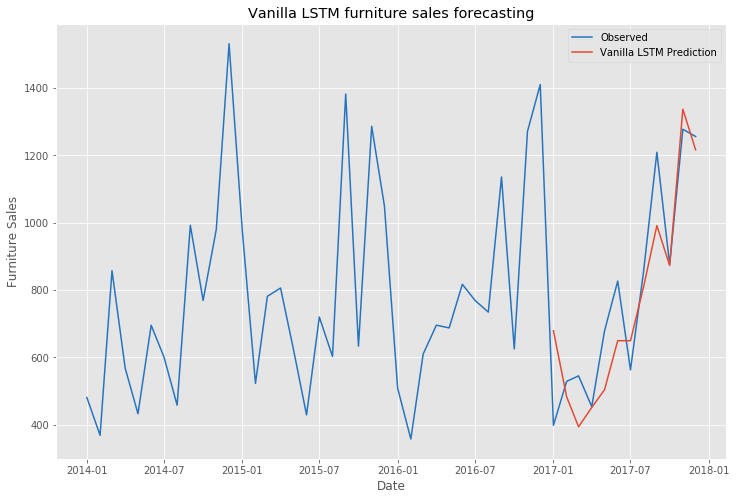

In [153]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [307]:
vanilla_lstm= performance(df[-12:],df_predict_vanilla['Prediction'] )
vanilla_lstm
#mmape can be 16

{'MSE': 19045.79, 'RMSE': 138.01, 'MAPE': 16.84}

### Stacked LSTM

In [161]:
model_stacked = Sequential()
#In stacked LSTM, we should output a sequence rather than a single value for each input -> return_sequences=True
model_stacked.add(LSTM(50, activation='relu', return_sequences = True, input_shape=(12, 1)))
model_stacked.add(LSTM(50, activation='relu'))
model_stacked.add(Dense(100, activation='relu'))
model_stacked.add(Dense(50, activation='relu'))
model_stacked.add(Dense(1))
model_stacked.compile(optimizer='adam', loss='mse')
#15



In [162]:
model_stacked.fit_generator(generator,epochs=200)

Epoch 1/200
3/3 [==============================] - 3s 877ms/step - loss: 0.2415
Epoch 2/200
3/3 [==============================] - 0s 46ms/step - loss: 0.2040
Epoch 3/200
3/3 [==============================] - 0s 37ms/step - loss: 0.1744
Epoch 4/200
3/3 [==============================] - 0s 32ms/step - loss: 0.1388
Epoch 5/200
3/3 [==============================] - 0s 37ms/step - loss: 0.1062
Epoch 6/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0718
Epoch 7/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0709
Epoch 8/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0852
Epoch 9/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0866
Epoch 10/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0783
Epoch 11/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0789
Epoch 12/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0742
Epoch 13/200
3/3 [==============================

In [163]:
pred_list_s = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list_s.append(model_stacked.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

df_predict_stacked = pd.DataFrame(scaler.inverse_transform(pred_list_s),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict_stacked], axis=1)

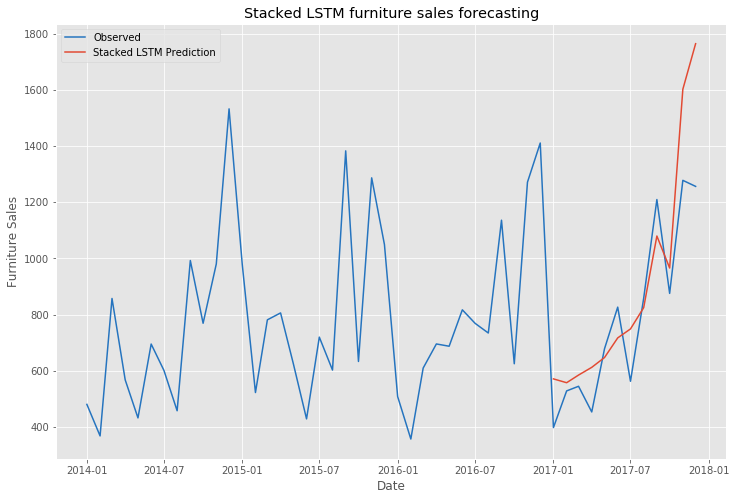

In [164]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,df_predict_stacked,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [309]:
stacked_lstm= performance(df[-12:],df_predict_stacked['Prediction'] )
stacked_lstm

{'MSE': 41237.44, 'RMSE': 203.07, 'MAPE': 19.44}

### Bidirectional LSTM

In [182]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

# define model
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(12, 1)))
model_bi.add(Dense(1))
model_bi.compile(optimizer='adam', loss='mse')

In [183]:
model_bi.fit_generator(generator,epochs=200)

Epoch 1/200
3/3 [==============================] - 3s 1s/step - loss: 0.2339
Epoch 2/200
3/3 [==============================] - 0s 43ms/step - loss: 0.2092
Epoch 3/200
3/3 [==============================] - 0s 38ms/step - loss: 0.1881
Epoch 4/200
3/3 [==============================] - 0s 31ms/step - loss: 0.1668
Epoch 5/200
3/3 [==============================] - 0s 34ms/step - loss: 0.1483
Epoch 6/200
3/3 [==============================] - 0s 33ms/step - loss: 0.1254
Epoch 7/200
3/3 [==============================] - 0s 34ms/step - loss: 0.1088
Epoch 8/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0918
Epoch 9/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0816
Epoch 10/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0676
Epoch 11/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0710
Epoch 12/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0731
Epoch 13/200
3/3 [==============================] -

In [184]:
pred_list_b = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list_b.append(model_bi.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_b[i]]],axis=1)

df_predict_bi = pd.DataFrame(scaler.inverse_transform(pred_list_b),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict_bi], axis=1)

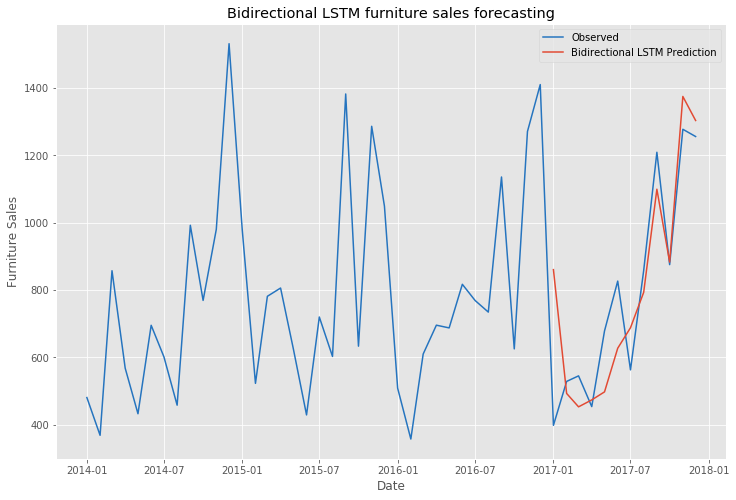

In [185]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction")
plt.title('Bidirectional LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [311]:
bi_lstm= performance(df[-12:],df_predict_bi['Prediction'] )
bi_lstm

{'MSE': 28414.2, 'RMSE': 168.57, 'MAPE': 20.55}

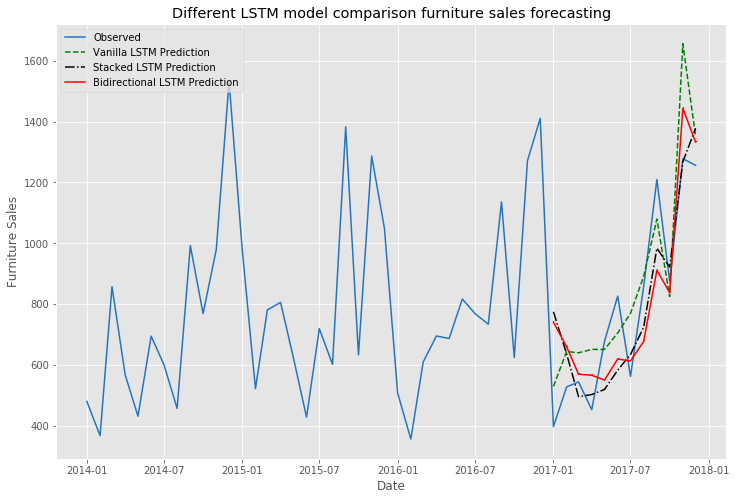

In [237]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='g')
#STacked LSTM
plt.plot(df[36:].index,df_predict_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="black")
#Bidirectional LSTM
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')
plt.title('Different LSTM model comparison furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend(loc='upper left')
plt.show()

### LSTM model 2

In [116]:
X = df.values

In [117]:
# Transform Time Series to Supervised Learning
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
# Make a differenced series to make time-series stationary
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [118]:
# Transform Time Series to Stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

In [119]:
# Transform Time Series to Supervised Learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [120]:
train_size = int(len(df) * 0.75)
trainset, testset= supervised_values[0:-12], supervised_values[-12:]

In [121]:
# Scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [122]:
#  Invert the scale on forecasts to the original scale
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [123]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(trainset, testset)

In [124]:
# fit an LSTM network to train the data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        #epoch can be changed to 1
        model.fit(X, y, epochs=5, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [125]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/5
35/35 [==============================] - 1s 26ms/step - loss: 0.2350
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2319
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2291
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2264
Epoch 5/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2237
Epoch 1/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2208
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2186
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2160
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2135
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2111
Epoch 1/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2075
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2063
Epoch 3/5
35/35 [==============================] - 0s 3ms/step 

35/35 [==============================] - 0s 2ms/step - loss: 0.1496
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1595
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1586
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1580
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1575
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1492
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1584
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1577
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1571
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1567
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1486
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1576
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1

35/35 [==============================] - 0s 2ms/step - loss: 0.1406
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1477
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1476
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1474
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1473
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1403
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1474
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1473
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1471
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1470
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1399
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1471
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1

35/35 [==============================] - 0s 2ms/step - loss: 0.1347
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1429
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1429
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1429
Epoch 5/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1429
Epoch 1/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1343
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1428
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1427
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1427
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1427
Epoch 1/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1342
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1427
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1

35/35 [==============================] - 0s 2ms/step - loss: 0.1317
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1423
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1419
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1418
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1416
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1307
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1413
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1413
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1412
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1412
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1298
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1412
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1

array([[-0.10050234],
       [ 0.05984524],
       [-0.43108112],
       [-0.09539579],
       [ 0.092259  ],
       [-0.11449957],
       [ 0.06925125],
       [ 0.24124332],
       [-0.27581137],
       [ 0.06240807],
       [-0.09333105],
       [-0.58622813],
       [-0.06287904],
       [ 0.28639734],
       [ 0.03814445],
       [ 0.09758581],
       [ 0.32673836],
       [ 0.48275268],
       [ 0.10284883],
       [ 0.3400846 ],
       [-0.52327895],
       [ 0.2854697 ],
       [-0.57163155],
       [-0.3488145 ],
       [ 0.21111305],
       [ 0.29837006],
       [ 0.05101372],
       [ 0.0477953 ],
       [ 0.14160575],
       [ 0.06114309],
       [ 0.1998535 ],
       [ 0.27709526],
       [-0.15089056],
       [ 0.5098989 ],
       [-0.38001847]], dtype=float32)

In [126]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [127]:
# walk-forward validation on the test data
predictions_lstm1 = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_lstm1.append(yhat)
    expected = raw_values[len(train_scaled) + i ]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=1011.923317, Expected=1410.719808
Month=2, Predicted=700.708661, Expected=397.602133
Month=3, Predicted=648.199606, Expected=528.179800
Month=4, Predicted=701.369963, Expected=544.672240
Month=5, Predicted=739.114394, Expected=453.297905
Month=6, Predicted=749.932770, Expected=678.302328
Month=7, Predicted=829.468859, Expected=826.460291
Month=8, Predicted=889.291324, Expected=562.524857
Month=9, Predicted=875.424319, Expected=857.881889
Month=10, Predicted=956.283634, Expected=1209.508583
Month=11, Predicted=993.075651, Expected=875.362728
Month=12, Predicted=1085.560810, Expected=1277.817759


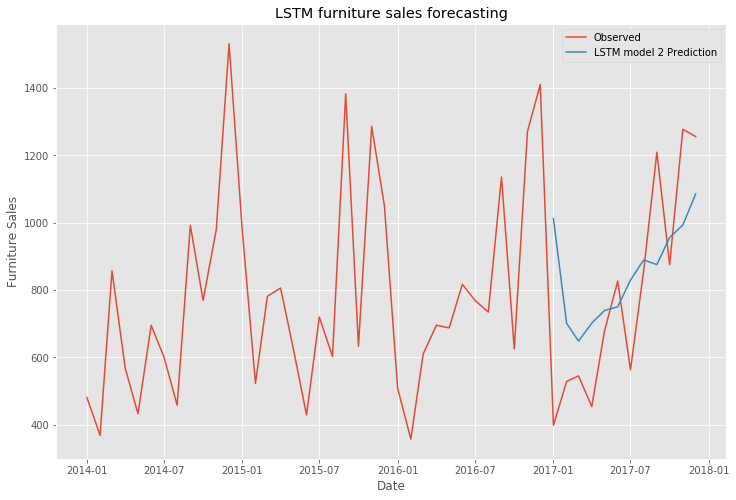

In [128]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 2 Prediction")
plt.title('LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [129]:
lstm2= performance(raw_values[-12:], predictions_lstm1)
lstm2

{'MSE': 65800.38, 'RMSE': 256.52, 'MAPE': 33.58}

Source: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

## Results:

In [315]:
# intialise data of lists. 
prediction_data = {'Model':['ARMA','ARIMA','SARIMA 1','SARIMA 2','DES','TES','Prophet1','Prophet2',
                           'Vanilla LSTM','Stacked LSTM','Bidirectional LSTM','LSTM 2'],
                   
                    'MSE':[arma_results['MSE'],arima_results['MSE'],sarima_results['MSE'],sarima_results2['MSE'], 
                           DES_results['MSE'],TES_results['MSE'],prophet_results['MSE'],prophet_results2['MSE'],
                           vanilla_lstm['MSE'],stacked_lstm['MSE'],bi_lstm['MSE'],lstm2['MSE']
                          ],
                  'RMSE':[arma_results['RMSE'],arima_results['RMSE'],sarima_results['RMSE'],sarima_results2['RMSE'], 
                          DES_results['RMSE'],TES_results['RMSE'],prophet_results['RMSE'],prophet_results2['RMSE'],
                          vanilla_lstm['RMSE'],stacked_lstm['RMSE'],bi_lstm['RMSE'],lstm2['RMSE']
                         ],
                  'MAPE':[arma_results['MAPE'],arima_results['MAPE'],sarima_results['MAPE'],sarima_results2['MAPE'],
                          DES_results['MAPE'],TES_results['MAPE'],prophet_results['MAPE'],prophet_results2['MAPE'],
                          vanilla_lstm['MAPE'],stacked_lstm['MAPE'],bi_lstm['MAPE'],lstm2['MAPE']
                         ]}
 
# Create DataFrame
prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Model,MSE,RMSE,MAPE
0,ARMA,87237.01,295.36,33.88
1,ARIMA,79804.31,282.50,35.07
2,SARIMA 1,42305.37,205.68,28.89
3,SARIMA 2,55497.86,235.58,33.50
4,DES,404596.36,636.08,98.79
5,TES,49846.48,223.26,30.81
6,Prophet1,37992.52,194.92,26.67
7,Prophet2,27986.56,167.29,22.62
8,Vanilla LSTM,19045.79,138.01,16.84
9,Stacked LSTM,41237.44,203.07,19.44


In [124]:
# intialise data of lists.
prediction_data = {
        'Test Set':testset,
        'ARMA':arma_predict,
        'ARIMA':arima_predict,
        'SARIMA':sarima_predict_1.predicted_mean,
        'DES':yhat_DES,
        'TES':yhat_TES,
        'Prophet1':test[36:48]['yhat'],
        'Prophet2':test2[36:48]['yhat']}
        
# Create DataFrame
prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Test Set,ARMA,ARIMA,SARIMA,DES,TES,Prophet1,Prophet2
2017-01-01,397.602133,713.539025,831.876478,803.994588,1261.313804,802.530280,804.654438,611.315808
2017-02-01,528.179800,719.933677,830.124459,461.016739,1282.552692,566.047823,601.206518,601.273761
2017-03-01,544.672240,725.734803,841.433484,717.583256,1303.791579,899.554170,782.905069,782.874892
2017-04-01,453.297905,730.997492,586.479319,764.867261,1325.030466,838.253706,754.585297,754.559898
2017-05-01,678.302328,735.771721,570.763305,648.086385,1346.269354,729.941441,685.352803,685.312958
2017-06-01,826.460291,740.102824,703.242018,572.567132,1367.508241,794.136733,805.507654,805.412353
2017-07-01,562.524857,744.031933,707.771683,737.887081,1388.747128,840.477777,792.293714,792.174728
2017-08-01,857.881889,747.596357,747.874806,651.320055,1409.986016,740.652523,714.448420,714.293365
2017-09-01,1209.508583,750.829946,843.043661,1291.261366,1431.224903,1311.992189,1208.615981,1208.430086
2017-10-01,875.362728,753.763407,855.413061,629.973778,1452.463790,816.216872,747.521868,747.343585


In [273]:
# intialise data of lists.
prediction_data2 = {
        'Test Set':df[-12:],
        'Vanilla LSTM':df_predict_vanilla['Prediction'],
        'Stacked LSTM':df_predict_stacked['Prediction'],
        'Bidirectional LSTM':df_predict_bi['Prediction'] }

# Create DataFrame
prediction_table2 = pd.DataFrame(prediction_data2)
prediction_table2

,Test Set,Vanilla LSTM,Stacked LSTM,Bidirectional LSTM
order_date,,,,
2017-01-01,397.602133,678.852616,571.001432,860.494506
2017-02-01,528.179800,482.619760,557.368542,492.351429
2017-03-01,544.672240,393.215240,584.620695,452.575804
2017-04-01,453.297905,450.673269,612.103891,473.191928
2017-05-01,678.302328,503.294647,647.035353,497.047099
2017-06-01,826.460291,649.230209,716.928402,626.824164
2017-07-01,562.524857,649.282387,748.883581,687.782988
2017-08-01,857.881889,810.726891,824.576567,792.981888
2017-09-01,1209.508583,991.521357,1079.674183,1099.614270


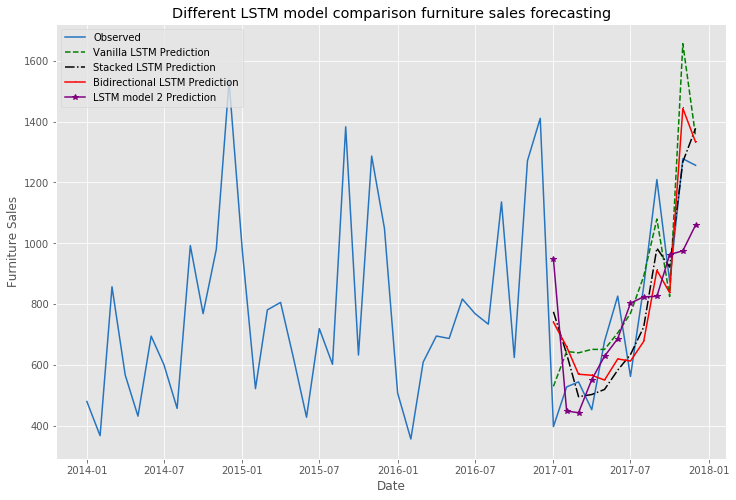

In [278]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='g')
#STacked LSTM
plt.plot(df[36:].index,df_predict_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="black")
#Bidirectional LSTM
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')
#LSTM model 2
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 2 Prediction",marker="*",color="purple")
plt.title('Different LSTM model comparison furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend(loc='upper left')
plt.show()

In [285]:
df.index

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', name='order_date', freq='MS')

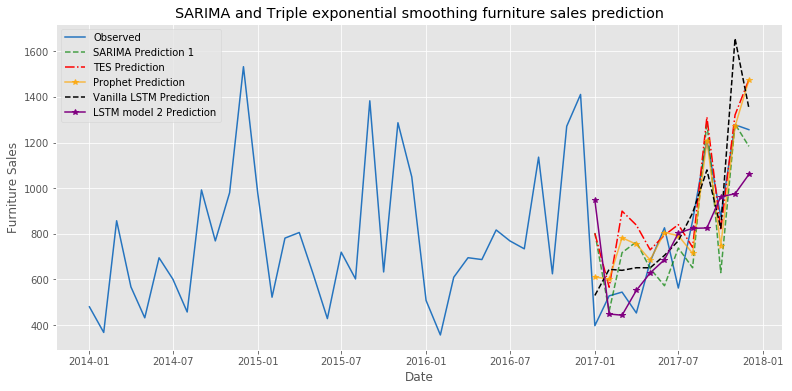

In [287]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
#observed plot
plt.plot(df.index, df, color='#2574BF',label='Observed')
#SARIMA
plt.plot(sarima_predict_1.predicted_mean, label='SARIMA Prediction 1', alpha= 0.7,linestyle= "--", color='g')
#TES
yhat_TES = TES_predict.values.tolist()
y = df.values.tolist()
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction',linestyle= "-.")
#Prophet 2
plt.plot(df[36:48].index,furniture_forecast2[36:48]['yhat'].values,label='Prophet Prediction', alpha= 0.7, color='Orange',marker= "*")
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='black')
#LSTM model 2
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 2 Prediction",marker="*",color="purple")
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('SARIMA and Triple exponential smoothing furniture sales prediction')
plt.show()

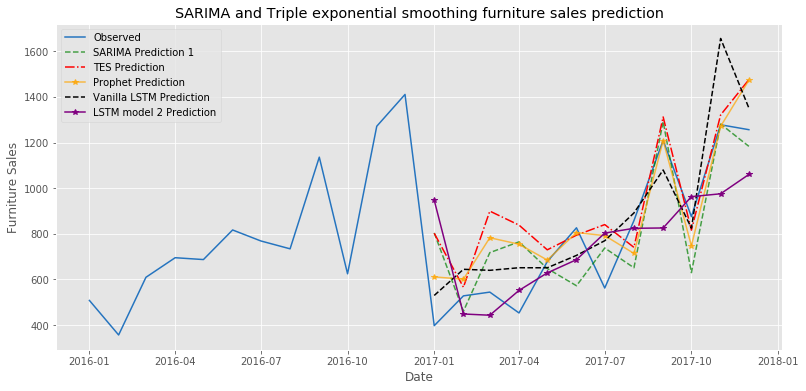

In [288]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
#observed plot
plt.plot(df[24:].index, df[24:], color='#2574BF',label='Observed')
#SARIMA
plt.plot(sarima_predict_1.predicted_mean, label='SARIMA Prediction 1', alpha= 0.7,linestyle= "--", color='g')
#TES
yhat_TES = TES_predict.values.tolist()
y = df.values.tolist()
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction',linestyle= "-.")
#Prophet 2
plt.plot(df[36:48].index,furniture_forecast2[36:48]['yhat'].values,label='Prophet Prediction', alpha= 0.7, color='Orange',marker= "*")
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='black')
#LSTM model 2
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 2 Prediction",marker="*",color="purple")
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('SARIMA and Triple exponential smoothing furniture sales prediction')
plt.show()